# Applications of Machine Learning in Remote Sensing
## Homework 4
Nakul Poudel – np1140@rit.edu
https://github.com/np1140/MLRemoteSensing

In [1]:
!pip install earthengine-api # Installing Google Earth Engine

In [2]:
!earthengine authenticate  # Authenticating to Earth Engine

E0000 00:00:1762110478.517957    1416 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762110478.541514    1416 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762110478.595668    1416 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762110478.595710    1416 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762110478.595715    1416 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762110478.595719    1416 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
import ee
ee.Initialize()   # Importing and Initializing Earth Engine

In [1]:
# !pip install geemap  # Visualizing an Image Using Geemap
# import geemap

In [163]:
#Lake:  Lake Fewa (approx. center coordinates)
# Latitude: 28.211, Longitude: 83.9497
lake_point = ee.Geometry.Point([83.94, 28.22])

# Create a Region of Interest (ROI)
# Buffer by 200 meters
lake_buffer = lake_point.buffer(200)

# Get the bounding box of this buffer
lake_bounds = lake_buffer.bounds()
lake_polygon = ee.Geometry.Polygon(lake_bounds.coordinates())

# Print the geometries to the console
print("Lake Point:", lake_point.getInfo())
print("Buffered Area (200m):", lake_buffer.getInfo())
print("Bounding Box:", lake_bounds.getInfo())

# Display in the Earth Engine Code Editor Map
Map = geemap.Map()
Map.centerObject(lake_point, 15)
Map.addLayer(lake_point, {'color': 'red'}, 'Lake Point')
Map.addLayer(lake_buffer, {'color': 'blue'}, 'Buffered 200m')
Map.addLayer(lake_bounds, {'color': 'green'}, 'Bounding Box')
Map.addLayer(lake_polygon, {'color': 'orange'}, 'Bounding Box Polygon')

Map


Lake Point: {'type': 'Point', 'coordinates': [83.94, 28.22]}
Buffered Area (200m): {'type': 'Polygon', 'coordinates': [[[83.94, 28.221799773190305], [83.93942947801438, 28.221728141033832], [83.93890437172566, 28.2215189467592], [83.9384664810712, 28.22118884297023], [83.93815066249307, 28.220764106901647], [83.93798205425722, 28.220278548447574], [83.93797407572619, 28.219770818612066], [83.9381273597563, 28.219281332717255], [83.93842970301952, 28.218849053335255], [83.93885703798739, 28.21850838902504], [83.93937534901964, 28.218286455685703], [83.93994337993954, 28.218200918436732], [83.94051591759447, 28.218258585716068], [83.94104739016493, 28.218454867430534], [83.94149549400173, 28.218774140257885], [83.94182456050747, 28.219190991044133], [83.94200839521072, 28.21967223939012], [83.94203236308857, 28.220179578523105], [83.94189455407007, 28.220672624329993], [83.94160593577305, 28.221112129907162], [83.94118948109974, 28.221463109756726], [83.94067833994144, 28.221697624898624

Map(center=[28.22, 83.94], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [165]:
import pandas as pd
landsat_name = 'LANDSAT/LC09/C02/T1_L2'
landsat8_collection = ee.ImageCollection(landsat_name) \
    .filterBounds(lake_polygon) \
    .filterDate('2021-10-31', '2025-10-17')  # date range

# Surface Temperature scale & offset
ST_SCALE = 0.00341802
ST_OFFSET = 149.0

# Function to extract ST band and convert to Kelvin

def add_LST_band(image):
    bands = image.bandNames()
    st_bands = bands.filter(ee.Filter.stringContains('item', 'ST_'))
    has_st = st_bands.size().gt(0)

    def scale_ST():
        st_img = image.select([st_bands.get(0)]).multiply(ST_SCALE).add(ST_OFFSET).rename('LST_K')
        return image.addBands(st_img).set('hasST', True)

    def no_ST():
        return image.set('hasST', False)

    return ee.Image(ee.Algorithms.If(has_st, scale_ST(), no_ST())).copyProperties(image)

# Map function over collection

landsat8_lst = landsat8_collection.map(add_LST_band).filter(ee.Filter.eq('hasST', True)) \
    .sort('system:time_start')

print("Total Landsat 8 scenes with ST:", landsat8_lst.size().getInfo())

# visualize an example scene using geemap
m = geemap.Map(center=[28.22, 83.94], zoom=15)
first_image = ee.Image(landsat8_lst.first())
m.addLayer(lake_polygon, {'color': 'yellow'}, 'Lake Polygon')
m


Total Landsat 8 scenes with ST: 166


Map(center=[28.22, 83.94], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [166]:
def mask_clouds_and_snow(image):
    # Select the QA_PIXEL band
    qa = image.select('QA_PIXEL')

    # Bits to check
    cloud_shadow_bit = 1 << 3
    snow_bit = 1 << 4
    cloud_bit = 1 << 5
    cirrus_bit = 1 << 9

    # Create a mask for all bad pixels
    mask = qa.bitwiseAnd(cloud_shadow_bit)\
             .Or(qa.bitwiseAnd(snow_bit))\
             .Or(qa.bitwiseAnd(cloud_bit))\
             .Or(qa.bitwiseAnd(cirrus_bit))\
             .eq(0)  # Keep only clear pixels

    # Apply the mask to all bands
    return image.updateMask(mask)


In [144]:
landsat8_lst_masked = landsat8_lst.map(mask_clouds_and_snow)
print("Total Landsat 8 scenes with ST and no clouds:", landsat8_lst_masked.size().getInfo())

Total Landsat 8 scenes with ST and no clouds: 86


In [145]:
def compute_mean_lst(image):
    # Select the correct LST band
    lst = image.select('LST_K')

    # Compute mean over ROI
    mean_dict = lst.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=lake_polygon,
        scale=30,
        maxPixels=1e9
    )

    mean_value = ee.Number(mean_dict.get('LST_K'))

    # Return as Feature
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'mean_LST_K': mean_value
    })


In [146]:
lst_features = ee.FeatureCollection(
    landsat8_lst_masked.map(compute_mean_lst)
).filter(ee.Filter.notNull(['mean_LST_K']))


In [147]:
lst_features

In [148]:
df = geemap.ee_to_df(lst_features) # convert to Pandas
df["landsat"] = landsat_name

print(df.head())


         date  mean_LST_K                 landsat
0  2022-05-18  276.436197  LANDSAT/LC09/C02/T1_L2
1  2022-06-19  284.381019  LANDSAT/LC09/C02/T1_L2
2  2022-07-05  286.116726  LANDSAT/LC09/C02/T1_L2
3  2022-10-25  275.863805  LANDSAT/LC09/C02/T1_L2
4  2022-11-26  272.585918  LANDSAT/LC09/C02/T1_L2


In [149]:
import os

# CSV file name
csv_file = "/content/drive/MyDrive/ML remotesensing/HW4/tilicho_data.csv"

# Check if file exists
if not os.path.isfile(csv_file):
    df.to_csv(csv_file, index=False)
else:
    df.to_csv(csv_file, mode='a', index=False, header=False)


## Visualization

---



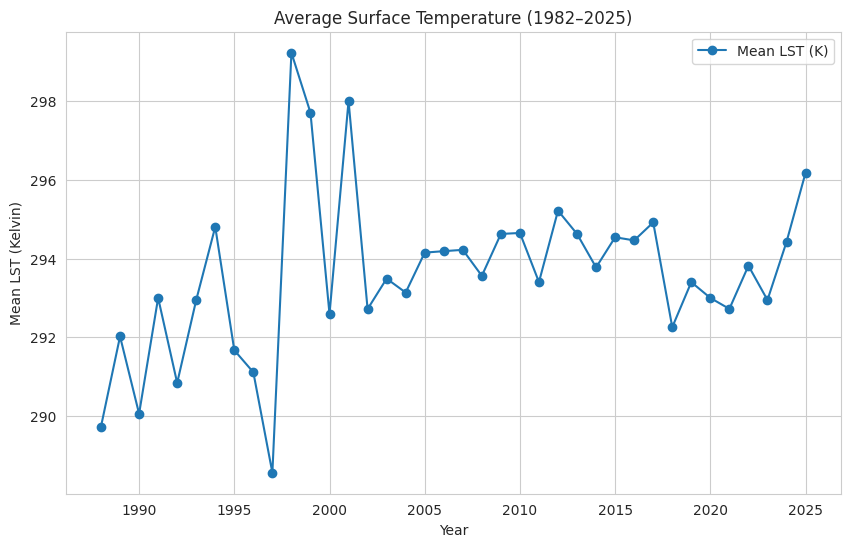

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/content/drive/MyDrive/ML remotesensing/HW4/fewa_lst_data.csv")

# Convert date to datetime and extract year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Compute mean LST per year
yearly_mean = df.groupby('year')['mean_LST_K'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(yearly_mean['year'], yearly_mean['mean_LST_K'], marker='o', linestyle='-', label='Mean LST (K)')
plt.title("Average Surface Temperature (1982–2025)")
plt.xlabel("Year")
plt.ylabel("Mean LST (Kelvin)")
plt.grid(True)
plt.legend()
plt.show()


## Temperature Trends over Well-Represented Years

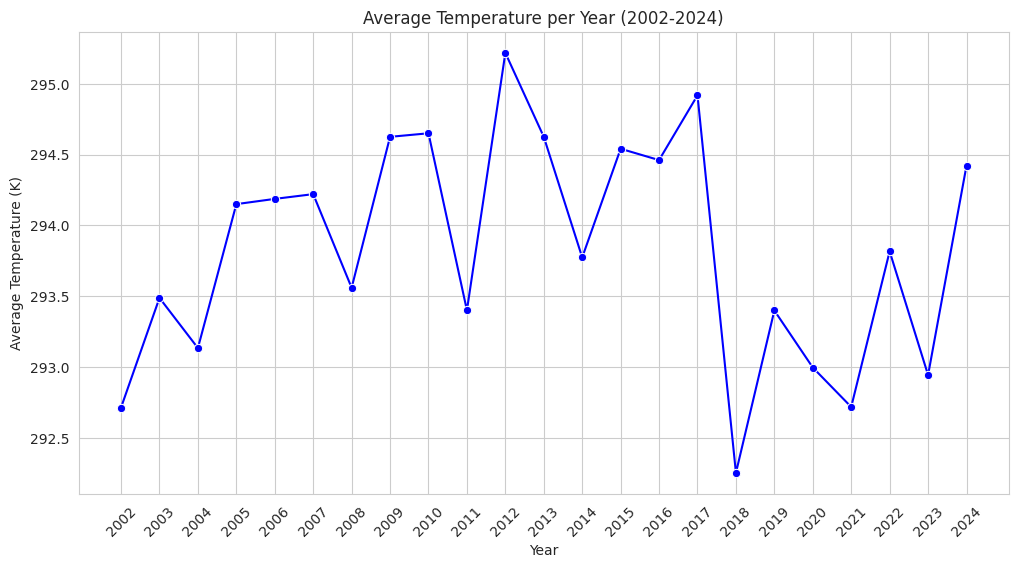

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
csv_file = "/content/drive/MyDrive/ML remotesensing/HW4/fewa_lst_data.csv"
df = pd.read_csv(csv_file)

df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Filter for years 2002 to 2024
df_filtered = df[(df['year'] >= 2002) & (df['year'] <= 2024)]

# Compute average temperature per year
avg_temp_per_year = df_filtered.groupby('year')['mean_LST_K'].mean().reset_index()

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='mean_LST_K', data=avg_temp_per_year, marker='o', color='b')
plt.title('Average Temperature per Year (2002-2024)')
plt.xlabel('Year')
plt.ylabel('Average Temperature (K)')
plt.xticks(avg_temp_per_year['year'], rotation=45)
plt.show()


The plot shows the average yearly temperature over time of Lake Fewa in Nepal. Data from Landsat 4 and 5 are sparse, making the early averages less reliable. Furthermore, since temperature varies throughout the year and only a few months are recorded in these early datasets, the averages may not fully reflect annual conditions. In contrast, data from Landsat 7, 8, and 9 after 2000 provide more comprehensive coverage, making the yearly averages more representative. Observing the period from 2002 onward, there is a slight increase in the lake’s temperature, with a cooler period between 2018 and 2021. From 2022 onward, temperatures rise again, reaching above 294 K in 2023. While this suggests a possible warming trend, it is not sufficient to conclusively confirm global warming for this lake.

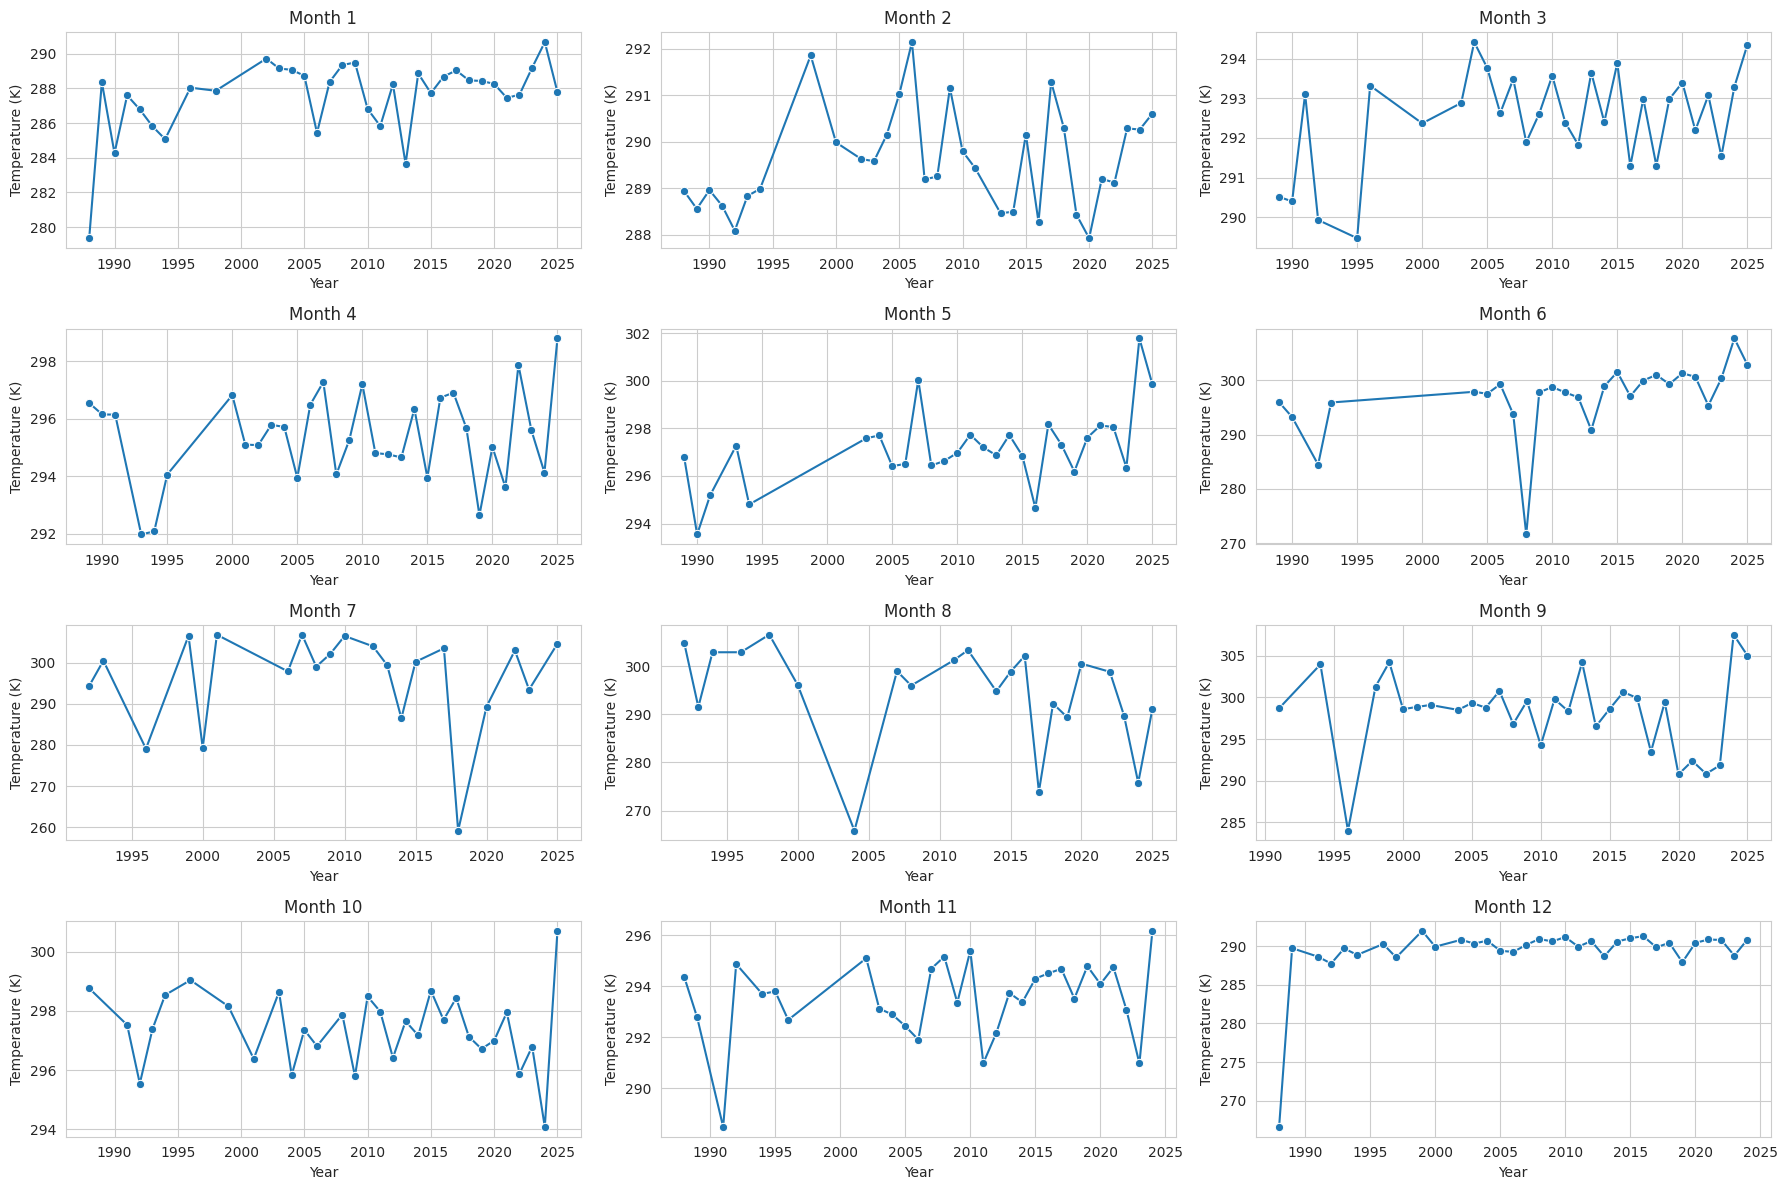

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
csv_file = "/content/drive/MyDrive/ML remotesensing/HW4/fewa_lst_data.csv"
df = pd.read_csv(csv_file)

df['date'] = pd.to_datetime(df['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Handle missing values
monthly_avg = df.groupby(['year', 'month'])['mean_LST_K'].mean().reset_index()

# Plotting style
sns.set_style("whitegrid")

# 12 plots, one per month
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month-1]
    data = monthly_avg[monthly_avg['month'] == month]
    sns.lineplot(x='year', y='mean_LST_K', data=data, ax=ax, marker='o')
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (K)')

plt.tight_layout()
plt.show()


In the plot above, we also visualized the monthly temperature variation from 1988 to the present.

In [186]:
import pandas as pd

# Load CSV
csv_file = "/content/drive/MyDrive/ML remotesensing/HW4/fewa_lst_data.csv"
df = pd.read_csv(csv_file)

df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Count number of data points per year for all years in the dataset
data_count_per_year = df.groupby('year').size().reset_index(name='data_count')

print(data_count_per_year)


    year  data_count
0   1988          11
1   1989          21
2   1990          11
3   1991          26
4   1992          21
5   1993          26
6   1994          21
7   1995           8
8   1996          14
9   1997           1
10  1998           6
11  1999           9
12  2000          11
13  2001          12
14  2002          11
15  2003          22
16  2004          43
17  2005          39
18  2006          37
19  2007          40
20  2008          50
21  2009          55
22  2010          45
23  2011          51
24  2012          33
25  2013          51
26  2014          66
27  2015          62
28  2016          65
29  2017          66
30  2018          57
31  2019          57
32  2020          61
33  2021          58
34  2022          93
35  2023          92
36  2024          51
37  2025          49


In [167]:
import pandas as pd

# Load CSV
csv_file = "/content/drive/MyDrive/ML remotesensing/HW4/fewa_lst_data.csv"
df = pd.read_csv(csv_file)

df['date'] = pd.to_datetime(df['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Count unique months per year
months_per_year = df.groupby('year')['month'].nunique().reset_index()
months_per_year.columns = ['year', 'unique_months']

# Filter years with all 12 months
complete_years = months_per_year[months_per_year['unique_months'] == 12]['year'].tolist()

print("Years with data for all 12 months:")
print(complete_years)


Years with data for all 12 months:
[2008, 2014, 2015, 2017, 2018, 2020, 2022, 2023]
